In [12]:
# from google.colab import drive
# drive.mount('/content/drive')

In [13]:
import os
# os.listdir("C:\\Users\\Mukul\\Documents\\docker\ files\\ee981")
# os.listdir('/mnt/c/Users/Mukul/Documents/docker files/ee981')

In [14]:
from PIL import Image
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2 #MobileNetV3Large
from tensorflow.keras.layers import Conv2D, concatenate, Input, BatchNormalization, Conv2DTranspose
# from tensorflow.keras.models import Model
import sklearn as skl
import matplotlib.pyplot as plt
import itertools
# from keras_unet_collection import models
import os



print("Tensorflow version " + tf.__version__)

# -- TPU code
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# print('Running on TPU ', tpu.cluster_spec().as_dict())

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# strategy = tf.distribute.experimental.TPUStrategy(tpu)
# print("REPLICAS: ", strategy.num_replicas_in_sync)


Tensorflow version 2.19.0


# 0.5 - Hyperparameters


In [15]:
BATCH_SIZE = 6
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.15
EPOCHS = 3
LEARNING_RATE = 0.01
IMAGE_SIZE = (2160,3840,3) # 3840 or 3480?
TARGET_SIZE = (720 ,720,3)

# 1 - Preprocessing

In [38]:

# RGB_FIRE_PATH  = '/content/drive/MyDrive/Colab Notebooks/Colab files/EE981/Images/'
# MASK_FIRE_PATH = '/content/drive/MyDrive/Colab Notebooks/Colab files/EE981/Masks/'
RGB_FIRE_PATH  = '/mnt/c/Users/Mukul/Documents/docker files/ee981/EE981/Images/'
MASK_FIRE_PATH = '/mnt/c/Users/Mukul/Documents/docker files/ee981/EE981/Masks/'

img_paths = [RGB_FIRE_PATH + 'image_' + str(i) + '.jpg' for i in range(2002)]
mask_paths  = [MASK_FIRE_PATH + 'image_' + str(i) + '.png' for i in range(2002)]

import os
os.path.exists(img_paths[1]) # sanity check


True

In [39]:
def show_img(*img_paths):
  for img_path in img_paths:
    img = np.array(Image.open(img_path))
    plt.imshow(img)
    plt.show()

In [41]:
train_paths_x,test_paths_x, train_paths_y, test_paths_y  = skl.model_selection.train_test_split(img_paths, mask_paths, test_size=TEST_SPLIT) # shuffles
# print(len(split[0]),len(split[1]))
# train_paths, test_paths = split[0], split[1]

# img = Image.open(train_paths_x[2])
# mask = Image.open(train_paths_y[2])
# mask = mask.point( lambda p: 255 if p == 1 else 0 )

In [63]:
zipped_paths = list(zip(train_paths_x,train_paths_y))

img_dataset = tf.data.Dataset.from_tensor_slices(zipped_paths)

def get_image(filename):
    img = tf.io.read_file(filename[0])
    mask = tf.io.read_file(filename[1])
    img = tf.image.decode_jpeg(img, channels=3)
    mask = tf.image.decode_png(mask)
    img = tf.image.resize(img,(TARGET_SIZE[0],TARGET_SIZE[1]),method ='bicubic')
    mask = tf.image.resize(mask,(TARGET_SIZE[0],TARGET_SIZE[1]), method = 'bicubic')
    return (img, mask)

img_dataset = img_dataset.map(get_image)
img_dataset = img_dataset.batch(BATCH_SIZE)

# for img in img_dataset.take(1):
#   plt.imshow(np.array(img[0]))
#   plt.show()
#   plt.imshow(np.array(img[1]))
#   plt.show()
# image_batch, label_batch = next(iter(img_dataset))
# plt.imshow(np.array(label_batch))
# img_dataset.element_spec


In [20]:
img_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 720, 720, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 720, 720, None), dtype=tf.float32, name=None))>

## Train UNET
 1. On thermal,
 2. On JPEG,
 3. On Smoke
## Make testing suite


# 2 - Constructing the U-Net Architecture

## 2.1 - U-Net Encoder Block

In [21]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning.
    Dropout can be added for regularization to prevent overfitting.
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow
    # Proper initialization prevents from the problem of exploding and vanishing gradients
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions
    skip_connection = conv

    return next_layer, skip_connection

## 2.2 - U-Net Decoder Block

In [22]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)

    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters,
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv



## 2.3 - Compile U-Net Blocks

In [23]:
def UNetCompiled(input_size=TARGET_SIZE, n_filters=32, n_classes=1):
   """
   Combine both encoder and decoder blocks according to the U-Net research paper
   Return the model as output
   """
   # Input size represent the size of 1 image (the size used for pre-processing)
   inputs = Input(input_size)

   # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
   # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image
   cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
   cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
   cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
   cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
   cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

   # Decoder includes multiple mini blocks with decreasing number of filters
   # Observe the skip connections from the encoder are given as input to the decoder
   # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
   ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
   ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
   ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
   ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

   # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
   # Followed by a 1x1 Conv layer to get the image to the desired size.
   # Observe the number of channels will be equal to number of output classes
   conv9 = Conv2D(n_filters,
               3,
               activation='relu',
               padding='same',
               kernel_initializer='he_normal')(ublock9)

   conv10 = Conv2D(1, 1, padding='same')(conv9)

   # Define the model
   model = tf.keras.Model(inputs=inputs, outputs=conv10)

   return model

In [24]:
os.listdir('/mnt/c/Users/Mukul/Documents/docker files/ee981/EE981')
# os.path.exists('/mnt/c/Users/Mukul/Documents/docker files/ee981/Masks/image_663.png')

['Images', 'Masks']

# 3 - Train / Load model


In [25]:
def train_model():
    model = UNetCompiled()
    # model2 = MobileNetV2(input_shape = TARGET_SIZE,classes =    )

    # tf.keras.utils.plot_model(model, "my_first_model.png")
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE),
                    loss='binary_crossentropy',
                    metrics=[ tf.keras.metrics.Precision(),
                            tf.keras.metrics.Recall(),
                            tf.keras.metrics.IoU(num_classes = 2,target_class_ids=[1]),
                            'accuracy'])

    # with lower filter can increase batch size>10
    history = model.fit(img_dataset,
                        epochs = EPOCHS,
                        callbacks = [ tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2) ]
                        )
    return model, history

def load_model(path):
    # print(os.listdir("../"))
    return tf.keras.models.load_model(path)
# model = load_model(os.path.join('../working_unet_720_720.keras'))
model, history = train_model()

Epoch 1/3


I0000 00:00:1743179858.026818   15962 service.cc:152] XLA service 0x7f68a0002e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743179858.026873   15962 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-03-28 16:37:38.248661: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743179859.064525   15962 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1743179894.391337   15962 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


284/284 ━━━━━━━━━━━━━━━━━━━━ 136s 339ms/step - accuracy: 0.9869 - io_u: 0.0090 - loss: 0.1418 - precision: 0.0071 - recall: 0.0082
Epoch 2/3


/home/mukulnarwani/venvs/EE992/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,io_u,loss,precision,recall
  current = self.get_monitor_value(logs)


284/284 ━━━━━━━━━━━━━━━━━━━━ 75s 264ms/step - accuracy: 0.9939 - io_u: 0.0000e+00 - loss: 0.0942 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/3
284/284 ━━━━━━━━━━━━━━━━━━━━ 76s 265ms/step - accuracy: 0.9939 - io_u: 0.0000e+00 - loss: 0.0942 - precision: 0.0000e+00 - recall: 0.0000e+00


# Things to try
- Reducing the filter size is critical to reduce the memory.
- Replacing upconvolution by interpolation
- Removing maxpool in favor of a convolution with stride
- Use in-place relu

# 4 - Plot and evaluate

In [65]:
zipped_paths = list(zip(test_paths_x,test_paths_y))

img_dataset = tf.data.Dataset.from_tensor_slices(zipped_paths)

# def get_image(filename):
#     img = tf.io.read_file(filename[0])
#     mask = tf.io.read_file(filename[1])
#     img = tf.image.decode_jpeg(img, channels=3)
#     mask = tf.image.decode_png(mask)
#     img = tf.image.resize(img,(TARGET_SIZE[0],TARGET_SIZE[1]))
#     mask = tf.image.resize(mask,(TARGET_SIZE[0],TARGET_SIZE[1]), method = 'bicubic')
#     # mask = tf.reshape(mask, (2160,3840,1))
#     return (img, mask)

test_dataset = img_dataset.map(get_image)
# test_dataset = test_dataset.batch(BATCH_SIZE)
input_img =  next(test_dataset.as_numpy_iterator())
print(input_img[0].shape)
mask = model.predict(np.array([input_img[0]]))
# for i,img in enumerate(test_dataset.take(5)):
#   if i ==3:
#     plt.imshow(np.array(img[0]))
#     # plt.show()
#     plt.imshow(np.array(img[1]))
#     # plt.show()
#     print(np.array(img[0]).shape)
#     model.predict(img[0])

(720, 720, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


-3252385500.0
[-0.0625     -0.05793811 -0.01161479 -0.0114928   0.          0.12066887
  0.5         0.8793311   0.9372692   1.          1.0116148   1.0579381
  1.0625    ]


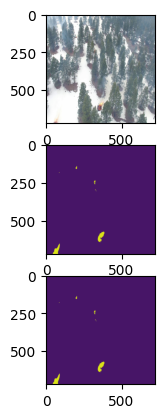

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1)
# np.array(list(input_img))
ax1.imshow(input_img[0].astype(np.uint8))
ax2.imshow(input_img[1])
# ax3.imshow(mask[0])
# THRESH = -10000000000
# threshed_mask = np.where(mask[0] < -THRESH, 0, 1)
ax3.imshow(input_img[1])

In [ ]:
# model.save('working_unet_720_720.keras')

# Load and predict video

In [ ]:
import  cv2

def process_vid_frame(frame):
    
    return tf.image.resize(frame,(TARGET_SIZE[0],TARGET_SIZE[1]))
prediction_frames = []
vid = cv2.VideoCapture('1-Zenmuse_X4S_1.mp4')
#Streaming has some overhead
while vid.isOpened():
    ret, frame = vid.read()
    input_img = process_vid_frame(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    # input_img = tf.image.resize(frame,(TARGET_SIZE[0],TARGET_SIZE[1]))
    # print(input_img)
    # plt.imshow(np.array(input_img).astype(np.uint8))
    # print()
    mask = model.predict(input_img[None, ...])
    prediction_frames.append(mask)
    
vid.release()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

In [4]:
model

NameError: name 'model' is not defined

KeyError: 'val_loss'

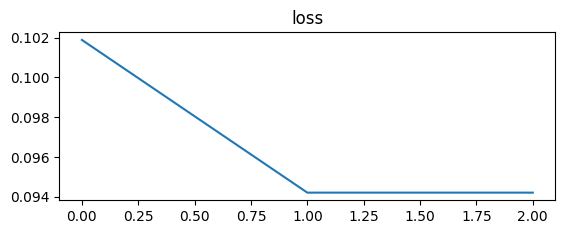

In [29]:
plt.subplot(212)
plt.title('loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

# 10 - TODO

1. Use cutouts, don't train on entire image